## About this kernel

This is the 3rd notebook I'm making using EfficientNet on TPUs. The full list:
1. https://www.kaggle.com/xhlulu/flowers-tpu-concise-efficientnet-b7
2. https://www.kaggle.com/xhlulu/plant-pathology-very-concise-tpu-efficientnet

If you want to dive deeper in the `tf.data.Dataset` way of building your input pipeline, please check out [this tutorial by Martin](https://codelabs.developers.google.com/codelabs/keras-flowers-data/#0), which I followed in order to build this kernel.

### References

* https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
* https://codelabs.developers.google.com/codelabs/keras-flowers-data/#0

In [1]:
!pip install -q efficientnet

In [2]:
import math, re, os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
import tensorflow as tf
import tensorflow.keras.layers as L
import efficientnet.tfkeras as efn
from sklearn import metrics
from sklearn.model_selection import train_test_split

## TPU Strategy and other configs 

In [3]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [4]:
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

# Configuration
EPOCHS = 20
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

## Load label and paths

In [5]:
def append_path(pre):
    return np.vectorize(lambda file: os.path.join(GCS_DS_PATH, pre, file))

In [6]:
sub = pd.read_csv('/kaggle/input/alaska2-image-steganalysis/sample_submission.csv')
train_filenames = np.array(os.listdir("/kaggle/input/alaska2-image-steganalysis/Cover/"))

In [7]:
np.random.seed(0)
positives = train_filenames.copy()
negatives = train_filenames.copy()
np.random.shuffle(positives)
np.random.shuffle(negatives)

jmipod = append_path('JMiPOD')(positives[:10000])
juniward = append_path('JUNIWARD')(positives[10000:20000])
uerd = append_path('UERD')(positives[20000:30000])

pos_paths = np.concatenate([jmipod, juniward, uerd])

In [8]:
test_paths = append_path('Test')(sub.Id.values)
neg_paths = append_path('Cover')(negatives[:30000])

In [9]:
train_paths = np.concatenate([pos_paths, neg_paths])
train_labels = np.array([1] * len(pos_paths) + [0] * len(neg_paths))

In [10]:
train_paths, valid_paths, train_labels, valid_labels = train_test_split(
    train_paths, train_labels, test_size=0.15, random_state=2020)

## Create Dataset objects

A `tf.data.Dataset` object is needed in order to run the model smoothly on the TPUs. Here, I heavily trim down [my previous kernel](https://www.kaggle.com/xhlulu/flowers-tpu-concise-efficientnet-b7), which was inspired by [Martin's kernel](https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu).

In [11]:
def decode_image(filename, label=None, image_size=(512, 512)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None):
    image = tf.image.central_crop(image, central_fraction=0.5)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.5) 
    image = tf.image.adjust_saturation(image, 3)
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.rot90(image)


#     image = tf.image.central_crop(image, central_fraction=0.5)
    
    if label is None:
        return image
    else:
        return image, label

In [12]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .cache()
    .repeat()
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, valid_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

## Modelling

### Helper Functions

In [13]:
def build_lrfn(lr_start=0.00001, lr_max=0.000075, 
               lr_min=0.000001, lr_rampup_epochs=20, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    return lrfn

### Load Model into TPU

In [14]:
with strategy.scope():
    model = tf.keras.Sequential([
        efn.EfficientNetB3(
            input_shape=(512, 512, 3),
            weights='imagenet',
            include_top=False
        ),
        L.GlobalAveragePooling2D(),
        L.Dense(1, activation='sigmoid')
    ])
        
    model.compile(
        optimizer='adam',
        loss = 'binary_crossentropy',
        metrics=['accuracy']
    )
    model.summary()

44113920/44107200 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Model)      (None, 16, 16, 1536)      10783528  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1537      
Total params: 10,785,065
Trainable params: 10,697,769
Non-trainable params: 87,296
_________________________________________________________________


### Start training

In [15]:
# lrfn = build_lrfn()
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
STEPS_PER_EPOCH = train_labels.shape[0] // BATCH_SIZE

history = model.fit(
    train_dataset, 
    epochs=EPOCHS, 
#     callbacks=[lr_schedule],
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=valid_dataset
)

Train for 398 steps, validate for 71 steps
Epoch 1/20
398/398 [==============================] - 2445s 6s/step - loss: 0.6750 - accuracy: 0.5520 - val_loss: 0.6813 - val_accuracy: 0.5471
Epoch 2/20
398/398 [==============================] - 142s 356ms/step - loss: 0.6435 - accuracy: 0.5904 - val_loss: 0.7033 - val_accuracy: 0.5858
Epoch 3/20
398/398 [==============================] - 142s 356ms/step - loss: 0.6283 - accuracy: 0.6068 - val_loss: 0.6256 - val_accuracy: 0.6131
Epoch 4/20
398/398 [==============================] - 142s 356ms/step - loss: 0.6128 - accuracy: 0.6254 - val_loss: 0.6261 - val_accuracy: 0.6160
Epoch 5/20
398/398 [==============================] - 142s 357ms/step - loss: 0.6041 - accuracy: 0.6378 - val_loss: 0.6125 - val_accuracy: 0.6241
Epoch 6/20
398/398 [==============================] - 142s 357ms/step - loss: 0.5967 - accuracy: 0.6408 - val_loss: 0.6221 - val_accuracy: 0.6120
Epoch 7/20
398/398 [==============================] - 142s 356ms/step - loss: 0.588

In [16]:
model.save("model.h5")

### Evaluation

Unhide below to see helper function `display_training_curves`:

In [17]:
def display_training_curves(training, validation, title, subplot):
    """
    Source: https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
    """
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

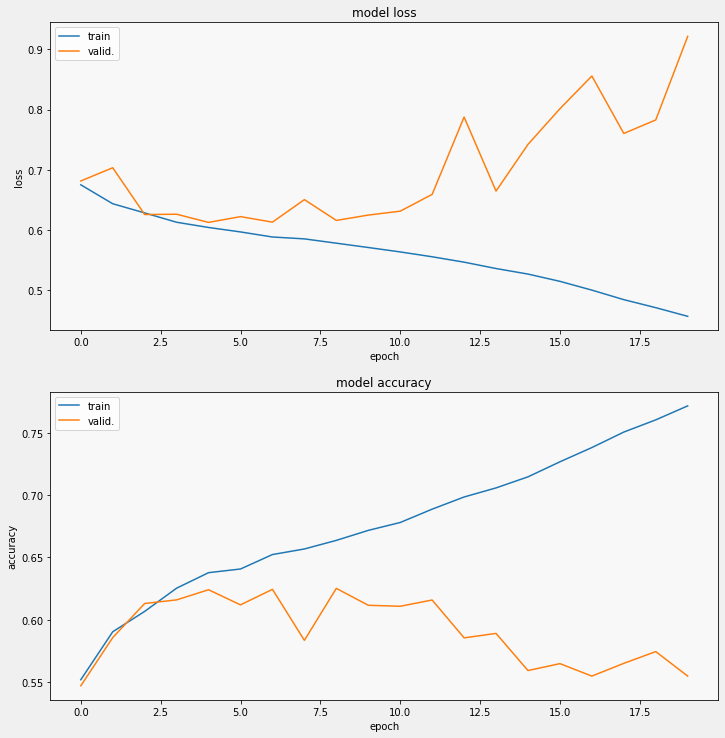

In [18]:
display_training_curves(
    history.history['loss'], 
    history.history['val_loss'], 
    'loss', 211)
display_training_curves(
    history.history['accuracy'], 
    history.history['val_accuracy'], 
    'accuracy', 212)

## Submission

In [19]:
sub.Label = model.predict(test_dataset, verbose=1)
sub.to_csv('submission.csv', index=False)
sub.head()

40/40 [==============================] - 245s 6s/step


,Id,Label
0,0001.jpg,0.210482
1,0002.jpg,0.311906
2,0003.jpg,0.576482
3,0004.jpg,0.822439
4,0005.jpg,0.356438
